## 1. Importing Libraries and Data

In [364]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pickle

import nltk
from nltk.corpus import wordnet
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
import tensorflow as tf
import tensorflow_hub as hub


from tensorflow.keras.preprocessing.text import Tokenizer

from tensorflow.keras.preprocessing.sequence import pad_sequences

In [325]:
df_fake = pd.read_csv('data/Fake.csv.gz')

In [326]:
df_fake['fake'] = 1

In [327]:
df_true = pd.read_csv('data/True.csv.gz')

In [328]:
df_true['fake'] = 0

In [329]:
df = pd.concat([df_fake, df_true], axis=0)

In [330]:
df = sklearn.utils.shuffle(df, random_state=42).reset_index(drop=True)

In [331]:
df.head()

,title,text,subject,date,fake
0,Ben Stein Calls Out 9th Circuit Court: Committ...,"21st Century Wire says Ben Stein, reputable pr...",US_News,"February 13, 2017",1
1,Trump drops Steve Bannon from National Securit...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"April 5, 2017",0
2,Puerto Rico expects U.S. to lift Jones Act shi...,(Reuters) - Puerto Rico Governor Ricardo Rosse...,politicsNews,"September 27, 2017",0
3,OOPS: Trump Just Accidentally Confirmed He Le...,"On Monday, Donald Trump once again embarrassed...",News,"May 22, 2017",1
4,Donald Trump heads for Scotland to reopen a go...,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",politicsNews,"June 24, 2016",0


In [332]:
df['fake'].value_counts()

1    23481
0    21417
Name: fake, dtype: int64

In [333]:
df.drop(columns=['text', 'subject', 'date'], inplace=True)
df.rename(columns={'title':'headline'}, inplace=True)

In [334]:
df.to_csv('data/data_cleaned.csv')

## 2. Preprocessing with NLTK

In [335]:
df['headline'] = df['headline'].apply(lambda x: re.sub(r"\<.*\>", "", x))

In [336]:
punctuation = '''!()-[]{};:"\,<>./?@#$%^&*_~'''

In [337]:
def remove_punctuation(review):
    cleaned = "".join([char for char in review if char not in punctuation])
    return cleaned

In [338]:
df['headline'] = df['headline'].apply(lambda x: remove_punctuation(x))

In [339]:
df.head()

,headline,fake
0,Ben Stein Calls Out 9th Circuit Court Committe...,1
1,Trump drops Steve Bannon from National Securit...,0
2,Puerto Rico expects US to lift Jones Act shipp...,0
3,OOPS Trump Just Accidentally Confirmed He Lea...,1
4,Donald Trump heads for Scotland to reopen a go...,0


In [340]:
df = df.loc[df['headline'] != '']

In [341]:
lemmatizer = WordNetLemmatizer()

In [342]:
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

In [343]:
def remove_stopwords(review_tokenized):
    no_stop = [word.lower() for word in review_tokenized if word.lower() not in stop_words]
    return no_stop

In [344]:
def lemmatize_review(review):
    tokenized = nltk.word_tokenize(review)
    no_stop = remove_stopwords(tokenized)
    nltk_tagged = nltk.pos_tag(no_stop)  
    wn_tagged = map(lambda x: (x[0], get_wordnet_pos(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wn_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:        
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

In [345]:
stop_words = stopwords.words("English")

In [346]:
df['headline'] = df['headline'].apply(lambda x: lemmatize_review(x))

In [347]:
df.head()

,headline,fake
0,ben stein call 9th circuit court commit ‘ coup...,1
1,trump drop steve bannon national security council,0
2,puerto rico expect us lift jones act ship rest...,0
3,oops trump accidentally confirm leak israeli i...,1
4,donald trump head scotland reopen golf resort,0


In [348]:
vectorizer = CountVectorizer(max_features=1000, min_df=5, max_df=0.7)
X = vectorizer.fit_transform(df['headline'].values)

In [349]:
X

<44898x1000 sparse matrix of type '<class 'numpy.longlong'>'
	with 277964 stored elements in Compressed Sparse Row format>

In [350]:
tfidf_converter = TfidfTransformer()
X = tfidf_converter.fit_transform(X).toarray()

In [351]:
len(X)

44898

In [352]:
y = df.drop(columns='headline')

## 3. Modelling with Scikit-learn

In [353]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [354]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1)

In [374]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [380]:
rand_forr = RandomForestClassifier(n_estimators=200, verbose=1)

In [420]:
params = {'max_depth':[1,10,100,1000], 'min_samples_leaf':[1,10,100,1000]}

In [421]:
clf = GridSearchCV(rand_forr, param_grid=params, cv=kfold, verbose=1)

In [422]:
clf.fit(X_train, y_train.values.ravel())

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed: 42.5min finished


KeyboardInterrupt: 

In [ ]:
def opt_plot(clf):
    opt = pd.DataFrame(clf.cv_results_)
    cols = [col for col in opt.columns if ('mean' in col or 'std' in col) and 'time' not in col]
    params = pd.DataFrame(list(opt.params))
    opt = pd.concat([params, opt[cols]], axis=1, sort=False)
    plt.figure(figsize=[12,9])
    sns.heatmap(pd.pivot_table(opt,
                               index='max_depth',
                               columns='min_samples_leaf',
                               values='mean_test_score')*100)
    plt.title('ROC_AUC - Validation')

In [ ]:
opt_plot(clf)

In [397]:
clf.score(X_train, y_train)

0.8744466136882338

In [398]:
clf.score(X_val, y_val)

0.8567186340014847

In [399]:
clf.score(X_test, y_test)

0.8650334075723831

## 4. Preprocessing with Tensorflow

In [140]:
df2 = pd.read_csv('data/data_cleaned.csv')
df2.drop(columns='Unnamed: 0', inplace=True)

In [141]:
df2 = df2.loc[df2['headline'] != '']

In [142]:
df2.head()

,headline,fake
0,Ben Stein Calls Out 9th Circuit Court: Committ...,1
1,Trump drops Steve Bannon from National Securit...,0
2,Puerto Rico expects U.S. to lift Jones Act shi...,0
3,OOPS: Trump Just Accidentally Confirmed He Le...,1
4,Donald Trump heads for Scotland to reopen a go...,0


In [158]:
X_train, X_test, y_train, y_test = train_test_split(df2['headline'].values, df2['fake'].values, test_size=0.1)

In [159]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1)

In [160]:
tokenizer = Tokenizer(num_words=1500, oov_token='UNK')

In [161]:
tokenizer.fit_on_texts(X_train)

In [162]:
X_train = tokenizer.texts_to_sequences(X_train)

In [163]:
max_length = max([len(x) for x in X_train])

In [164]:
max_length

44

In [165]:
lengths = [len(x) for x in X_train]

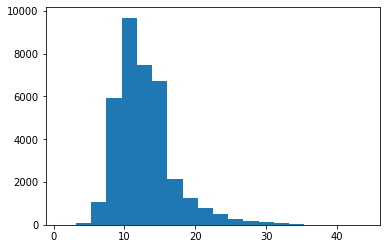

In [166]:
plt.hist(lengths, bins=20)
plt.show()

In [167]:
X_train = pad_sequences(X_train, padding='post', truncating='post', maxlen=20)

In [241]:
with open('tokenizer_news.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [168]:
X_val = tokenizer.texts_to_sequences(X_val)
X_val = pad_sequences(X_val, padding='post', truncating='post', maxlen=20)

In [184]:
X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, padding='post', truncating='post', maxlen=20)

In [259]:
input_data = tf.keras.layers.Input(shape=(20))
 
data = tf.keras.layers.Embedding(input_dim=1500, output_dim=32, input_length=20)(input_data)
 
data = tf.keras.layers.Conv1D(50, kernel_size=3, activation='relu', padding='same')(data)
data = tf.keras.layers.MaxPool1D(pool_size=2)(data)
 
data = tf.keras.layers.Conv1D(40, kernel_size=3, activation='relu', padding='same')(data)
data = tf.keras.layers.MaxPool1D(pool_size=2)(data)
 
data = tf.keras.layers.Conv1D(30, kernel_size=3, activation='relu', padding='same')(data)
data = tf.keras.layers.MaxPool1D(pool_size=2)(data)
 
data = tf.keras.layers.Conv1D(30, kernel_size=3, activation='relu', padding='same')(data)
data = tf.keras.layers.MaxPool1D(pool_size=2)(data)
 
data = tf.keras.layers.Flatten()(data)
 
data = tf.keras.layers.Dense(20)(data)
data = tf.keras.layers.Dropout(0.5)(data)
 
data = tf.keras.layers.Dense(1)(data)
output_data = tf.keras.layers.Activation('sigmoid')(data)
 
model = tf.keras.models.Model(inputs=input_data, outputs=output_data)
 
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 20)]              0         
_________________________________________________________________
embedding_13 (Embedding)     (None, 20, 32)            48000     
_________________________________________________________________
conv1d_42 (Conv1D)           (None, 20, 50)            4850      
_________________________________________________________________
max_pooling1d_39 (MaxPooling (None, 10, 50)            0         
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 10, 40)            6040      
_________________________________________________________________
max_pooling1d_40 (MaxPooling (None, 5, 40)             0         
_________________________________________________________________
conv1d_44 (Conv1D)           (None, 5, 30)             3630

In [260]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                            mode='auto',
                                            restore_best_weights=True)

In [261]:
history = model.fit(X_train,
                    y_train,
                    epochs=20,
                    batch_size=256,
                    validation_data=(X_val, y_val),
                    use_multiprocessing=True,
                    callbacks=[callback])

Train on 36367 samples, validate on 4041 samples
Epoch 1/20
36367/36367 [==============================] - 10s 287us/sample - loss: 0.2659 - accuracy: 0.8872 - val_loss: 0.1569 - val_accuracy: 0.9399
Epoch 2/20
36367/36367 [==============================] - 9s 236us/sample - loss: 0.1015 - accuracy: 0.9652 - val_loss: 0.1057 - val_accuracy: 0.9569
Epoch 3/20
36367/36367 [==============================] - 9s 240us/sample - loss: 0.0805 - accuracy: 0.9721 - val_loss: 0.0960 - val_accuracy: 0.9644
Epoch 4/20
36367/36367 [==============================] - 9s 245us/sample - loss: 0.0654 - accuracy: 0.9780 - val_loss: 0.1172 - val_accuracy: 0.9550


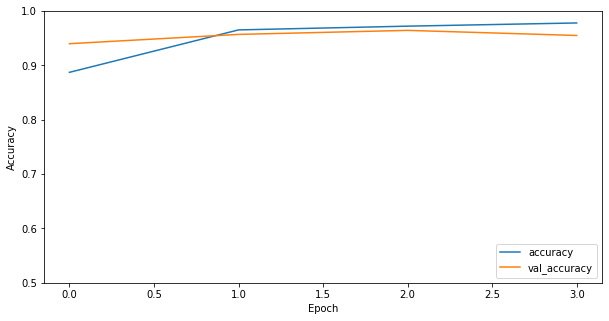

In [265]:
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

In [306]:
test_metrics = model.evaluate(X_test, y_test, verbose=0)

In [307]:
print(f'Model loss: {round(test_metrics[0], 3)} \nModel accuracy: {round(test_metrics[1], 3)}')

Model loss: 0.098 
Model accuracy: 0.9649999737739563


In [187]:
model.save("conv_net_news.h5")

In [188]:
model = tf.keras.models.load_model("conv_net_news.h5")

In [268]:
def predict_review(model, sentence):
    sentence = tokenizer.texts_to_sequences([sentence])
    sentence = pad_sequences(sentence, padding='post', truncating='post', maxlen=20)
    prediction = model.predict(sentence)
    probability = prediction[0][0]
    if prediction[0] > 0.5:
        print(f'This news article is FAKE! \nThe model is {np.round(probability * 100, 1)}% confident the headline of the article is fake.')
    if prediction[0] < 0.5:
        print(f'This news article is TRUE! \nThe model is {np.round((1-probability) * 100, 1)}% confident the headline of the article is true.')

In [319]:
headline = "Trump is a lunatic"

In [320]:
predict_review(model, headline)

This news article is TRUE! 
The model is 95.0% confident the headline of the article is true.
